In [1]:
%%capture
import stata_setup, os
if os.name == 'nt':
    stata_setup.config('C:/Program Files/Stata17/','mp')
else:
    stata_setup.config('/usr/local/stata17','mp')

In [2]:
%%stata -qui

use "../data/data", clear
rename log_automated_readability_index ARI
quietly tabulate year, generate(y_)
quietly tabulate cluster, generate(c_)

local journals ecm jpe qje res  //AER based category

local jel_imp a_imp b_imp c_imp  e_imp f_imp g_imp h_imp i_imp j_imp k_imp /// 
		l_imp m_imp n_imp o_imp p_imp q_imp r_imp y_imp z_imp // D JEL based case

In [3]:
%%stata
*net install schemepack, from("https://raw.githubusercontent.com/asjadnaqvi/stata-schemepack/main/installation/") replace
*set scheme white_piyg
*twoway (scatter ARI log_flesch_kincaid_grade_level) ///
*       (function y=x, range(1.5 4.5)) ///
*       , xscale(range(1.5 4.5)) yscale(range(1.5 4.5))


. *net install schemepack, from("https://raw.githubusercontent.com/asjadnaqvi/s
> tata-schemepack/main/installation/") replace
. *set scheme white_piyg
. *twoway (scatter ARI log_flesch_kincaid_grade_level) ///
> *       (function y=x, range(1.5 4.5)) ///
> *       , xscale(range(1.5 4.5)) yscale(range(1.5 4.5))
. 


In [4]:
%%stata -qui
#delimit ;
reg ARI log_num_authors log_num_pages both_genders only_males
			`journals' `jel_imp' y_2-y_20  c_2-c_215  jel_flag, vce(cluster cluster);
matrix b_selected = e(b)[1,"log_num_authors"],e(b)[1,"log_num_pages"],
                    e(b)[1,"both_genders"],e(b)[1,"only_males"],e(b)[1,"_cons"];
#delimit cr

In [5]:
%%stata
matrix list b_selected


b_selected[1,5]
    log_num_au~s  log_num_pa~s  both_genders    only_males         _cons
y1     .00218908     .02298592     .01266277      .0189557     2.6904442


In [6]:
%%stata -qui
#delimit ;
vl set log_num_authors log_num_pages both_genders only_males
       `journals' `jel_imp' y_2-y_20  c_2-c_215 jel_flag
       , dummy clear nonotes;
vl create fe = vldummy - (only_males both_genders jel_flag);
vl substitute mfe = i.fe;
vl create controls = vlcontinuous;
vl create controls_dummy = (both_genders jel_flag);
vl substitute baseline = i.controls_dummy controls;
vl rebuild;
#delimit cr

In [7]:
%%stata -qui
#delimit ;
reg ARI only_males $baseline $mfe, vce(cluster cluster);
matrix b_selected = e(b)[1,"log_num_authors"],e(b)[1,"log_num_pages"],
                    e(b)[1,"1.both_genders"],e(b)[1,"only_males"],e(b)[1,"_cons"];
#delimit cr

In [8]:
%%stata
matrix list b_selected


b_selected[1,5]
                                           1.                            
    log_num_au~s  log_num_pa~s  both_genders    only_males         _cons
y1     .00218908     .02298592     .01266277      .0189557     2.6904442


In [9]:
%%stata
summarize automated_readability_index, detail
local cutoff = r(p95)
gen int ARI_01 = (automated_readability_index >= `cutoff')


. summarize automated_readability_index, detail

      Automated readability index score for the article
-------------------------------------------------------------
      Percentiles      Smallest
 1%     10.14504       5.194678
 5%     11.81832       7.517143
10%     12.72031       7.581272       Obs               4,988
25%     14.18133       7.610606       Sum of wgt.       4,988

50%     15.98628                      Mean           16.23712
                        Largest       Std. dev.      3.149588
75%     17.86968       35.86604
90%     20.04869         36.178       Variance       9.919907
95%     21.38507       52.27347       Skewness       1.885853
99%     25.20484       68.08047       Kurtosis       22.74376

. local cutoff = r(p95)

. gen int ARI_01 = (automated_readability_index >= `cutoff')

. 


In [10]:
%stata summarize ARI_01


    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
      ARI_01 |      4,988    .0499198    .2178011          0          1


In [13]:
%%stata -qui
#delimit ;
logit ARI_01 i.only_males $baseline $mfe, vce(cluster cluster) nolog;
#delimit cr

In [14]:
%%stata
estimates table, keep(log_num_authors log_num_pages 1.both_genders 1.only_males) b(%5.4f) star varwidth(25)


----------------------------------------
                 Variable |   Active    
--------------------------+-------------
          log_num_authors | -0.1506     
            log_num_pages |  0.7096***  
           1.both_genders |  0.6463     
             1.only_males |  0.6594**   
----------------------------------------
Legend: * p<0.05; ** p<0.01; *** p<0.001


In [24]:
%%stata -qui
#delimit ;
margins, dydx(only_males) at(log_num_pages=(1(0.5)4.5)
                             log_num_authors=0.60205999132 (base) _factor);
#delimit cr


. set scheme white_piyg

. marginsplot, yline(0) recast(line) title("Marginal Effects of Only Males on A
> RI")

Variables that uniquely identify margins: log_num_pages

. 


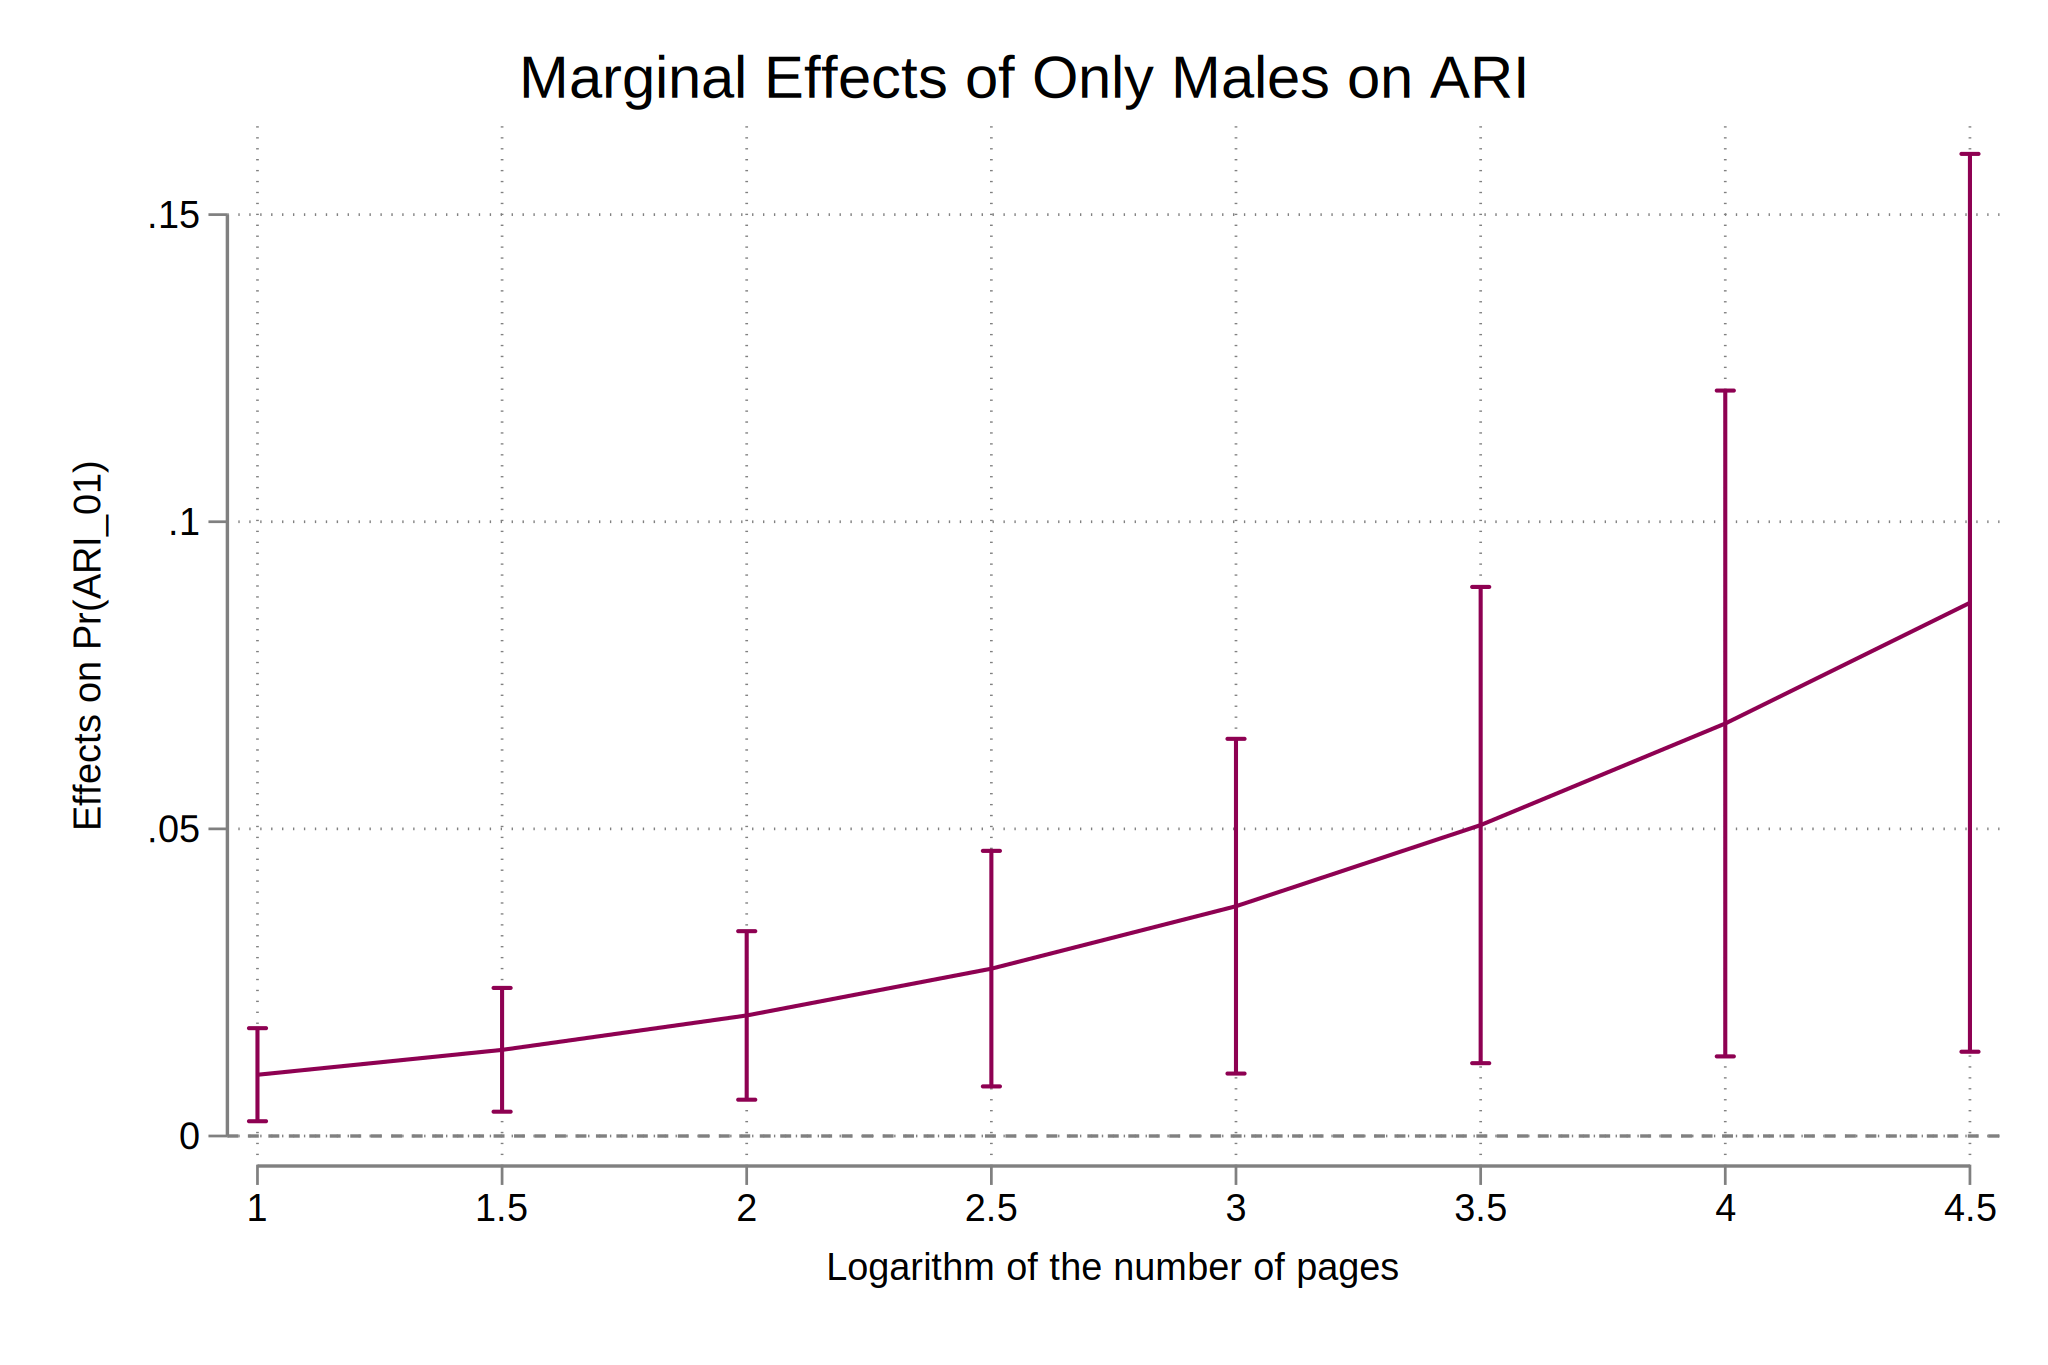

In [25]:
%%stata
set scheme white_piyg
marginsplot, yline(0) recast(line) title("Marginal Effects of Only Males on ARI")